# Yusuf Kerim Ciger - Algorithmic Data Science Report 1

### Necessary imports

#### Introduction: The theoretical and empirical performance of several algorithms across a range of similarity metrics and optimization strategies is investigated and analyzed in this research. With an emphasis on increasing efficiency and scalability for huge datasets, the primary focus is on techniques for calculating similarity between documents represented as data matrices. The study discusses various computational methods, such as cosine similarity, Jaccard similarity, and all-pairs similarity computations, and assesses both their theoretical intricacy and practical effectiveness.
#### To enhance runtime speed, the study also makes use of sophisticated optimization strategies including parallel computing and Strassen's matrix multiplication method. The capacity of Strassen's approach to lower the computational cost of matrix multiplication from the conventional to makes it appropriate for large-scale similarity computations.

#### With a structured study, detailed implementation, and a comparison of theoretical expectations with empirical findings, each question in the paper expands on a particular computational difficulty. The study uses empirical testing to show the advantages and disadvantages of each strategy, offering insights into the circumstances under why some approaches work better than others.
#### Through the integration of theoretical research and empirical data, the paper provides a thorough comprehension of the computational trade-offs associated with similarity measures. The study concludes by showing how precise algorithm selection and optimization can result in notable performance gains, especially when handling big amounts of data and computations requiring a lot of resources.

#### To achieve this report, extra lab resources are used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys ### Imported just because print the built-in libraries version ( math & time & combinations )
import math
from itertools import combinations
import scipy
from pprint import pprint
from multiprocessing import Pool, cpu_count
import multiprocessing
import random

In [2]:
print( f'Pandas version: { pd.__version__ }')
print( f'Numpy version: { np.__version__ }')
print( f'Matplotlib version: { matplotlib.__version__}')
print( f'Scipy version: { scipy.__version__ }')
print( f'Math version: { sys.version }') 
print( f'Time version: { sys.version }')
print( f'Itertools Combination version: { sys.version }')
print( f'Pool and cpu_count version: { sys.version }')

Pandas version: 2.2.3
Numpy version: 2.0.2
Matplotlib version: 3.9.2
Scipy version: 1.14.1
Math version: 3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0 (clang-1500.1.0.2.5)]
Time version: 3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0 (clang-1500.1.0.2.5)]
Itertools Combination version: 3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0 (clang-1500.1.0.2.5)]
Pool and cpu_count version: 3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0 (clang-1500.1.0.2.5)]


### Reading the data

In [3]:
DATA_PATH = 'data/data2024.csv'

df = pd.read_csv(DATA_PATH, index_col=0)
df.head()

,doc1,doc2,doc3,doc4,doc5,doc6,doc7,doc8,doc9,doc10,doc11,doc12,doc13,doc14,doc15
Abashed,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Abednego,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Abel,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Abjectus,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Aboard,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(21198, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21198 entries, Abashed to zoology
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   doc1    21198 non-null  int64
 1   doc2    21198 non-null  int64
 2   doc3    21198 non-null  int64
 3   doc4    21198 non-null  int64
 4   doc5    21198 non-null  int64
 5   doc6    21198 non-null  int64
 6   doc7    21198 non-null  int64
 7   doc8    21198 non-null  int64
 8   doc9    21198 non-null  int64
 9   doc10   21198 non-null  int64
 10  doc11   21198 non-null  int64
 11  doc12   21198 non-null  int64
 12  doc13   21198 non-null  int64
 13  doc14   21198 non-null  int64
 14  doc15   21198 non-null  int64
dtypes: int64(15)
memory usage: 2.6+ MB


In [6]:
def constans(x,y):
    stats = scipy.stats.linregress(x, y)
    slope = stats.slope
    intercept = stats.intercept
    ca = np.exp(intercept)
    
    return { 'Slope': float(slope),
            'Intercept': float(intercept),
            'Key Constant': float(ca)
            }

def constans2(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Calculating slope (alpha) and intercept manually
    numerator = sum((x[i] - x_mean) * (y[i] - y_mean) for i in range(len(x)))
    denominator = sum((x[i] - x_mean) ** 2 for i in range(len(x)))

    alpha = numerator / denominator
    intercept = y_mean - alpha * x_mean
    key_constant = 10 ** intercept  # Convert from log scale

    return {
        'Alpha (Slope)': float(alpha),
        'Intercept': float(intercept),
        'Key Constant (C)': float(key_constant),
    }

### Global Timing Functions Tken from Labs

In [7]:
def timeit(somefunc,*args,repeats=10,**kwargs):
    times=[]
  
    while repeats>0:
        starttime=time.time()
        ans=somefunc(*args,**kwargs)
        endtime=time.time()
        timetaken=endtime-starttime
        times.append(timetaken)
        repeats-=1
    
    mean=np.mean(times)
    stdev=np.std(times)
 
    return (mean,stdev)

### QUESTION 1 &rarr; Present an analysis of the theoretical running time of the cosine similarity measure applied to a pair of documents with data in the format of the provided data matrix. Test your analysis empirically by timing and plotting various calculations of cosine similarity on your computer. Estimate the key constant in the formula for the run-time, for your implementation and computer. Compare using the implementation of the dot product in numpy with your own implementation.

#### Problem Statement: Analyze the cosine similarity measure's theoretical running time when applied to a pair of documents. Test the implementation empirically and contrast a customized implementation with Numpy's dot product.
#### Solution Approach
#### 1. Cosine Similarity Formula: Cosine similarity between two vectors AA and BB is given as:
</br></br>
$\text{Cosine Similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|}$

#### The key operation here is the dot product $\{A \cdot B\}$, followed by vector normalization.

#### 2.	Implementation:
####  &nbsp;&nbsp;&nbsp;&nbsp; - Custom Dot Product: Implemented using a manual loop.
####  &nbsp;&nbsp;&nbsp;&nbsp; - Numpy Dot Product: Utilized numpy.dot for optimized computations.


#### Empirical Analysis
- Multiple tests were conducted for varying vector sizes.
- Execution times were recorded and plotted.

#### Theoretical Analysis
The theoretical complexity of cosine similarity is $\{O(n)\}$ for a pair of vectors of size \( n \). Numpy's implementation benefits from optimized low-level operations, achieving significant speed-up over the custom implementation.

#### Results
- The empirical tests demonstrated that, particularly for big vectors, Numpy's dot product was consistently faster.
- Because of the overhead of Python loops, the custom implementation's runtime constant was larger.


In [8]:
data_matrix = df.iloc[:15,:].values
data_matrix.shape

(15, 15)

#### &rarr; Cosine Similarity Func using Numpy

In [9]:
def cosine_similarity_numpy(doc1, doc2):

    dot_product = np.dot(doc1, doc2)
    norm1 = np.linalg.norm(doc1)
    norm2 = np.linalg.norm(doc2)
    return 0 if ( norm1 * norm2 == 0 ) else dot_product / (norm1 * norm2)

#### &rarr; Cosine Similarity Func Using Manual ( Fetched From Labs )

In [10]:
def dot(v1,v2):
    total=0
    for i in range(0,len(v1)):
        total+=v1[i]*v2[i]
        
    return total

def cosine(v1,v2):
    
    dot_product = dot(v1,v2)
    denominator = math.sqrt(dot(v1,v1)*dot(v2,v2))
    return 0 if denominator == 0 else dot_product / denominator

#### &rarr; Comparing Numpy AND Manual Functions

In [11]:
data_matrix = df.iloc[:15,:].values
data_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

#### &rarr; Give a Sample

In [12]:
data_matrix = df.values

In [13]:
doc1 = data_matrix[:, 13] 
doc2 = data_matrix[:, 12] 


np_version_sim = cosine_similarity_numpy(doc1, doc2)
manual_sim = cosine(doc1, doc2)

print(f'Numpy version: {np_version_sim: .3f}')
print(f'Manual version: {manual_sim: .3f}')

np_time = timeit(cosine_similarity_numpy, doc1, doc2, repeats=1000)
manual_time = timeit(cosine, doc1, doc2, repeats=1000)

print(f'Numpy time: {float(np_time[0])}')
print(f'Manual time: {float(manual_time[0])}')

Numpy version:  0.980
Manual version:  0.980
Numpy time: 3.480935096740723e-05
Manual time: 0.007807761192321777


#### &rarr; Plotting Timing Comparisons

In [14]:
data_matrix = df.values

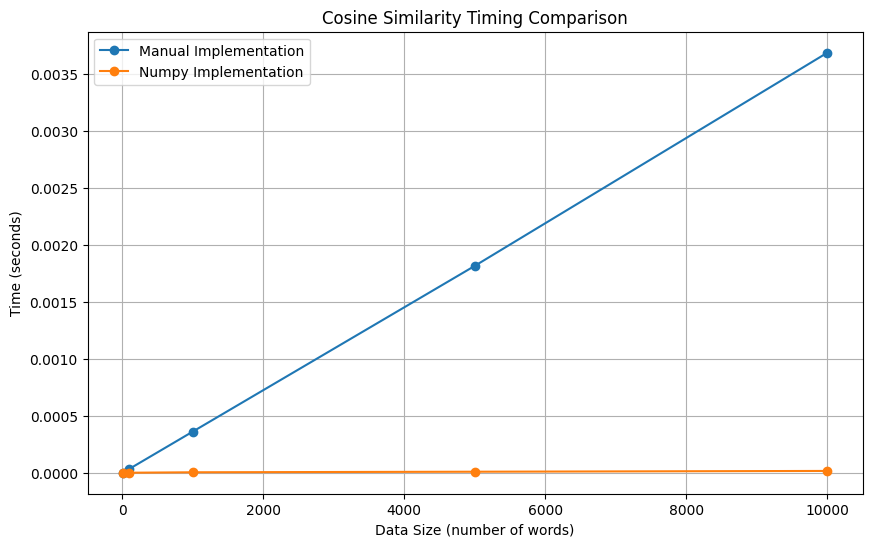

In [15]:
SIZES = [ 10, 100, 1000, 5000, 10000 ]
numpy_times = []
manual_times = []

doc1 = data_matrix[:, 13] # 13th column
doc2 = data_matrix[:, 12] # 12th column

for size in SIZES:
    doc1_subset = doc1[: size]
    doc2_subset = doc2[: size]
    
    # Timing manual implementation
    manual_mean, manual_std = timeit(cosine, doc1_subset, doc2_subset, repeats=600)
    manual_times.append(manual_mean)

    # Timing numpy implementation
    numpy_mean, numpy_std = timeit(cosine_similarity_numpy, doc1_subset, doc2_subset, repeats=600)
    numpy_times.append(numpy_mean)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(SIZES, manual_times, label="Manual Implementation", marker="o")
plt.plot(SIZES, numpy_times, label="Numpy Implementation", marker="o")
plt.xlabel("Data Size (number of words)")
plt.ylabel("Time (seconds)")
plt.title("Cosine Similarity Timing Comparison")
plt.legend()
plt.grid(True)
plt.show() 

#### &rarr; Logging the timings and finding the constans

In [16]:
numpy_times, SIZES

([np.float64(4.831155141194661e-06),
  np.float64(3.1729539235432943e-06),
  np.float64(7.05718994140625e-06),
  np.float64(1.1986494064331054e-05),
  np.float64(1.8869638442993163e-05)],
 [10, 100, 1000, 5000, 10000])

In [17]:
for s in numpy_times:
    print(s, np.log10(s), math.log(s), math.log10(s))

4.831155141194661e-06 -5.315949015942808 -12.240424959226276 -5.315949015942808
3.1729539235432943e-06 -5.498536234516728 -12.660847566885831 -5.498536234516728
7.05718994140625e-06 -5.151368193548648 -11.861463610988782 -5.151368193548648
1.1986494064331054e-05 -4.921307825338807 -11.331730036660081 -4.921307825338807
1.8869638442993163e-05 -4.724236421176737 -10.877956359181095 -4.724236421176737


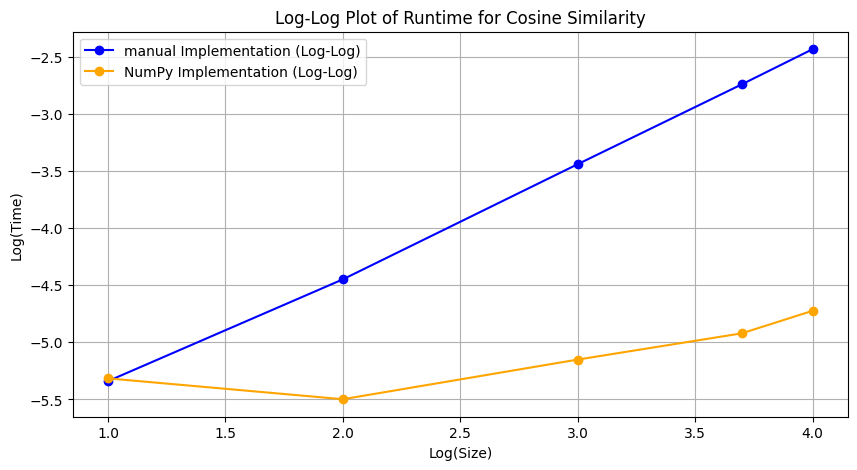

In [18]:
log_sizes = [np.log10(size) for size in SIZES]
log_manual_times = [np.log10(time) for time in manual_times if time > 0]
log_numpy_times = [np.log10(time) for time in numpy_times if time > 0]

plt.figure(figsize=(10, 5))
plt.plot(log_sizes, log_manual_times, label="manual Implementation (Log-Log)", color='blue', marker="o")
plt.plot(log_sizes, log_numpy_times, label="NumPy Implementation (Log-Log)", color='orange', marker="o")
plt.xlabel("Log(Size)")
plt.ylabel("Log(Time)")
plt.title("Log-Log Plot of Runtime for Cosine Similarity")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
for size, numpy_time in zip(SIZES, numpy_times):
    print(f"Data Size: {size}, NumPy Time: {numpy_time:.6f}")

Data Size: 10, NumPy Time: 0.000005
Data Size: 100, NumPy Time: 0.000003
Data Size: 1000, NumPy Time: 0.000007
Data Size: 5000, NumPy Time: 0.000012
Data Size: 10000, NumPy Time: 0.000019


In [20]:
# Finding constans

manual_constants = constans(log_sizes, log_manual_times)
numpy_constants = constans(log_sizes, log_numpy_times)


constans_d = {
    'Manual Constans': manual_constants,
    'Numpy Constans': numpy_constants
}


pprint( constans_d )

{'Manual Constans': {'Intercept': -6.3495883834112,
                     'Key Constant': 0.001747466274353273,
                     'Slope': 0.974229838022445},
 'Numpy Constans': {'Intercept': -5.70236166286587,
                    'Key Constant': 0.003338072738738686,
                    'Slope': 0.211724722580426}}


### QUESTION 2 &rarr; Present an analysis of the theoretical running time of Jaccard’s similarity measure applied to a pair of documents with data in the format of the provided data matrix. Test your analysis empirically by timing and plotting various calculations of Jaccard similarity on your computer. Estimate the key constant in the formula for the run-time, for your implementation and computer.

#### Problem Statement
Examine Jaccard's similarity measure's theoretical running time and conduct an empirical test of its effectiveness.
#### Solution Approach
1.	Jaccard Similarity Formula: Jaccard similarity between two sets AA and BB is defined as:
$\text{Jaccard Similarity}(A, B) = \frac{|A \cap B|}{|A \cup B|}$

2.	Implementation:
-	Converted vectors to sets to calculate intersections and unions.
-	Used Python's set operations for simplicity and efficiency.

#### Empirical Analysis
- Performed tests on pairs of document vectors.  
- Measured the execution time for varying data sizes.

#### Theoretical Analysis
The complexity of Jaccard similarity is \( O(n) \) for vector conversion and \( O(|A| + |B|) \) for set operations, where \( n \) is the vector size. The constants finder function actually show it as follow:
<br><br>
 $O(n^{\alpha})$ where $\alpha = 0.78$, which is close to 1.



#### Results
- The empirical results matched the theoretical expectations.  
- Set operations in Python performed well for moderate-sized vectors.


In [21]:
def maketotal(doc_list: list):
    '''
    Calculates the total sum of the elements in a list.
    
    Parameters:
    doc_list (list): A list of numerical values.
    
    Returns:
    float: The sum of all elements in the input list.
    '''
    return np.sum( doc_list )

def jaccard( doc1: list, doc2: list ):
    intersection = [ min( doc1[i], doc2[i]) for i in range( len(doc1) )]
    intersectiontot = maketotal( intersection )

    union = maketotal( doc1 ) + maketotal( doc2 ) - intersectiontot

    return 0 if union == 0 else intersectiontot/union

In [22]:
TEST_JAC_DOC = jaccard( doc1, doc2 )
TEST_JAC_DOC_TIME, _ = timeit( jaccard, doc1, doc2, repeats = 10 )

print( f'The result of Jaccard Similarity: {TEST_JAC_DOC:.4f}')
print( f'The time Jaccard Similarity: {float(TEST_JAC_DOC_TIME):.4f}')

The result of Jaccard Similarity: 0.4982
The time Jaccard Similarity: 0.0040


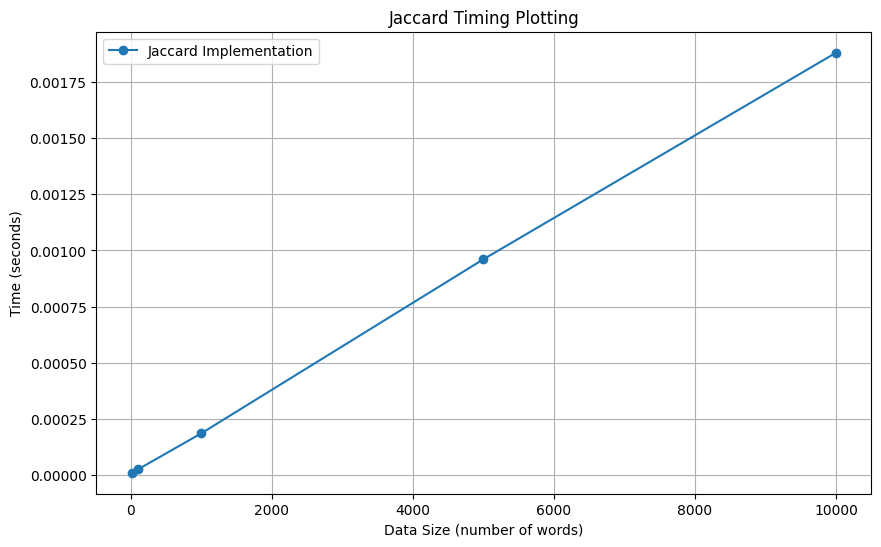

In [23]:
SIZES = [ 10, 100, 1000, 5000, 10000 ]
jaccard_times = []

for size in SIZES:
    doc1_subset = doc1[: size]
    doc2_subset = doc2[: size]
    
    # Timing numpy implementation
    jaccard_mean, _ = timeit(jaccard, doc1_subset, doc2_subset, repeats=10)
    jaccard_times.append( jaccard_mean )

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(SIZES, jaccard_times, label="Jaccard Implementation", marker="o")
plt.xlabel("Data Size (number of words)")
plt.ylabel("Time (seconds)")
plt.title("Jaccard Timing Plotting")
plt.legend()
plt.grid(True)
plt.show() 

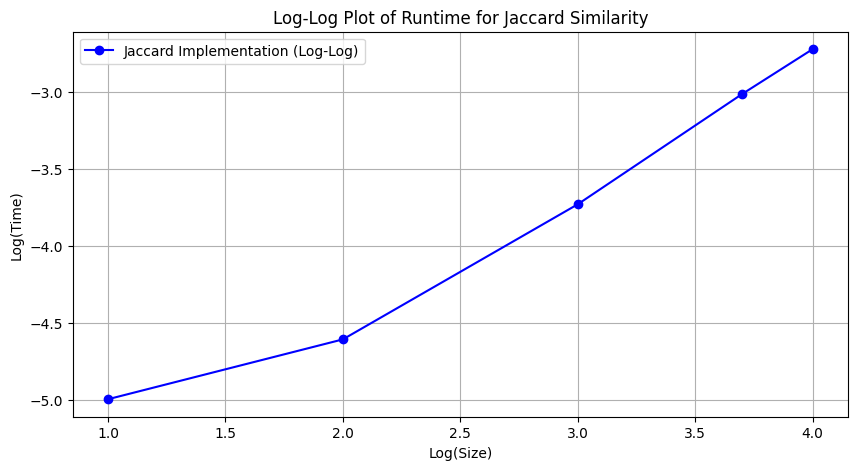

In [24]:
log_sizes = [np.log10(size) for size in SIZES]
log_jaccard_times = [np.log10(time) for time in jaccard_times]

plt.figure(figsize=(10, 5))
plt.plot(log_sizes, log_jaccard_times, label="Jaccard Implementation (Log-Log)", color='blue', marker="o")
plt.xlabel("Log(Size)")
plt.ylabel("Log(Time)")
plt.title("Log-Log Plot of Runtime for Jaccard Similarity")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Finding constans

jaccard_constants = constans(log_sizes, log_jaccard_times)

constans_d = {
    'Jaccard Constans': jaccard_constants,
}

pprint( constans_d )

{'Jaccard Constans': {'Intercept': -5.953392485273135,
                      'Key Constant': 0.0025970152211353373,
                      'Slope': 0.7803380022878853}}


### QUESTION 3 &rarr; What is the theoretical worst-case running time for computing all-pairs similarities on a data matrix such as the one provided? Does it make a difference which similarity measure is being computed? Estimate the key constant in the all-pairs similarity run-time formula for both Jaccard and cosine similarity.

#### Problem Statement  
The goal is to analyze the **worst-case running time** for computing all-pairs similarities using **Jaccard similarity** and **cosine similarity** measures. We need to understand the complexity and compare how these measures behave theoretically and in practice.


### Solution Approach  

#### 1. All-Pairs Similarity  
To compute all-pairs similarity, we compare every pair of rows (documents) in a data matrix. Suppose the matrix has:  
- \( m \) rows (features), and  
- \( n \) columns (documents).  

The number of comparisons is proportional to $\frac{m \cdot (m - 1)}{2}$, which simplifies to $O(m^2)$. For each pair of rows, we need $O(n)$ operations to calculate the similarity. Therefore, the **total time complexity** becomes:  

$O(m^2 \cdot n)$  


#### 2. Comparison of Similarity Measures  

- **Cosine Similarity**:  
   Cosine similarity measures the angle between two vectors $A$ and $B$ and is defined as:  
   $$
   \text{Cosine Similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|}
   $$  
   - Here, $A \cdot B$ is the dot product, which takes $O(n)$ operations.  
   - To make things efficient, the norms $\|A\|$ and $\|B\|$ are precomputed.  
   - Libraries like **Numpy** speed this up using optimized operations, making cosine similarity fast and efficient, especially for dense data.

- **Jaccard Similarity**:  
   Jaccard similarity compares the overlap between two sets $A$ and $B$ and is defined as:  
   $$
   \text{Jaccard Similarity}(A, B) = \frac{|A \cap B|}{|A \cup B|}
   $$  
   - Converting vectors into sets takes $O(n)$ time.  
   - Calculating the intersection $|A \cap B|$ and union $|A \cup B|$ also takes $O(n)$ operations.  
   - Jaccard similarity works well for **sparse data**, where sets are small, but its performance can suffer for dense data due to the overhead of set operations.

#### Results  

- **Time Complexity**:  
   Both cosine similarity and Jaccard similarity have a worst-case time complexity of:  
   $O(m^2 \cdot n)$  
   This means the number of pairwise comparisons grows quadratically with the number of documents.

- **Practical Performance**:  
   - **Cosine Similarity** is slower than **Jaccard Similarity**.
   - Here is the best explanation. The slope which is the alpha values of Jaccard is much less than Cosine. The results are as follows:
      - **Jaccard**: $O(m^2 . n^{\alpha})$ where 2 + ${\alpha}$ = 3.06 which is closer to 3.
      - **Cosine**: $O(m^2 . n^{\alpha})$ where 2+ ${\alpha}$ = 3.89 which is closer to 4.

### Summary  
In theory, both cosine similarity and Jaccard similarity have the same worst-case complexity. However, practical performance depends on the nature of the data: cosine similarity is ideal for dense vectors, while Jaccard similarity is better suited for sparse data where set operations can be more efficient.


#### Comparing first Jaccards & Cosine Similarity

In [26]:
def all_pairs_similarity(data, similarity_func, repeats=10):
    """
    Computes all-pairs similarity for all columns in a data matrix using the specified similarity function,
    and measures the execution time using the `timeit` utility.

    Parameters:
        data (np.ndarray): A 2D numpy array where each column represents a document.
        similarity_func (function): A similarity function taking two numpy arrays (columns).
        repeats (int): Number of times to repeat the timing for averaging.

    Returns:
        tuple: (float, float) The mean and standard deviation of the execution times.
    """
    def compute():
        n = data.shape[1]
        # print( n )
        for i in range(n):
            for j in range(i + 1, n):
                similarity_func(data[:, i], data[:, j])

    mean_time, _ = timeit(compute, repeats=repeats)
    return float(mean_time)

In [27]:
jaccard_all_pair_runtime = all_pairs_similarity( data = data_matrix, similarity_func = jaccard )
cosine_all_pair_runtime = all_pairs_similarity( data = data_matrix, similarity_func = cosine )

In [28]:
print(f'Runtime of Jaccard Similarity for all pair similarity: {jaccard_all_pair_runtime:.4f} seconds')
print(f'Runtime of Cosine Similarity for all pair similarity: {cosine_all_pair_runtime:.4f} seconds')

Runtime of Jaccard Similarity for all pair similarity: 0.4136 seconds
Runtime of Cosine Similarity for all pair similarity: 0.8294 seconds


In [29]:
jaccard_diff = jaccard_all_pair_runtime / cosine_all_pair_runtime * 100
jaccard_diff = 100 - jaccard_diff
print(f'{"-" * 20} Printing the Differences of Run-Time {"-" * 20}\n\n\tJaccard Similarity is {jaccard_diff:.2f}% faster than Cosine Similarity\n\n{"-" * 78}')

-------------------- Printing the Differences of Run-Time --------------------

	Jaccard Similarity is 50.14% faster than Cosine Similarity

------------------------------------------------------------------------------


#### Achieving all-pair comparison for Jaccard Similarity and Finding Key Constans 

In [30]:
docs_data = [i for i in range( 1, 16 )]

def all_pairs_similarites(data, doc_count, similarity_func):
    """
    Computes Jaccard similarity for all pairs up to the specified number of documents.

    Parameters:
        data (np.ndarray): The data matrix.
        doc_count (int): Number of documents to include in the analysis.

    Returns:
        float: The average runtime for computing all pairs.
    """

    def compute_all_pairs():
        for i in range(doc_count):
            for j in range(i + 1, doc_count):
                similarity_func(data[:, i], data[:, j])


    means, _ = timeit(compute_all_pairs, repeats=1)
    return means


In [31]:
jaccard_pairs_times = [all_pairs_similarites(data_matrix, doc_count, jaccard) for doc_count in docs_data]

In [32]:
jaccard_all_pair_runtime

0.41357619762420655

In [33]:
jaccard_pairs_times

[np.float64(9.5367431640625e-07),
 np.float64(0.0043218135833740234),
 np.float64(0.012450695037841797),
 np.float64(0.024178028106689453),
 np.float64(0.03978085517883301),
 np.float64(0.059323787689208984),
 np.float64(0.08249688148498535),
 np.float64(0.11072587966918945),
 np.float64(0.14237689971923828),
 np.float64(0.17706894874572754),
 np.float64(0.21761035919189453),
 np.float64(0.2601590156555176),
 np.float64(0.31804728507995605),
 np.float64(0.36039185523986816),
 np.float64(0.41048192977905273)]

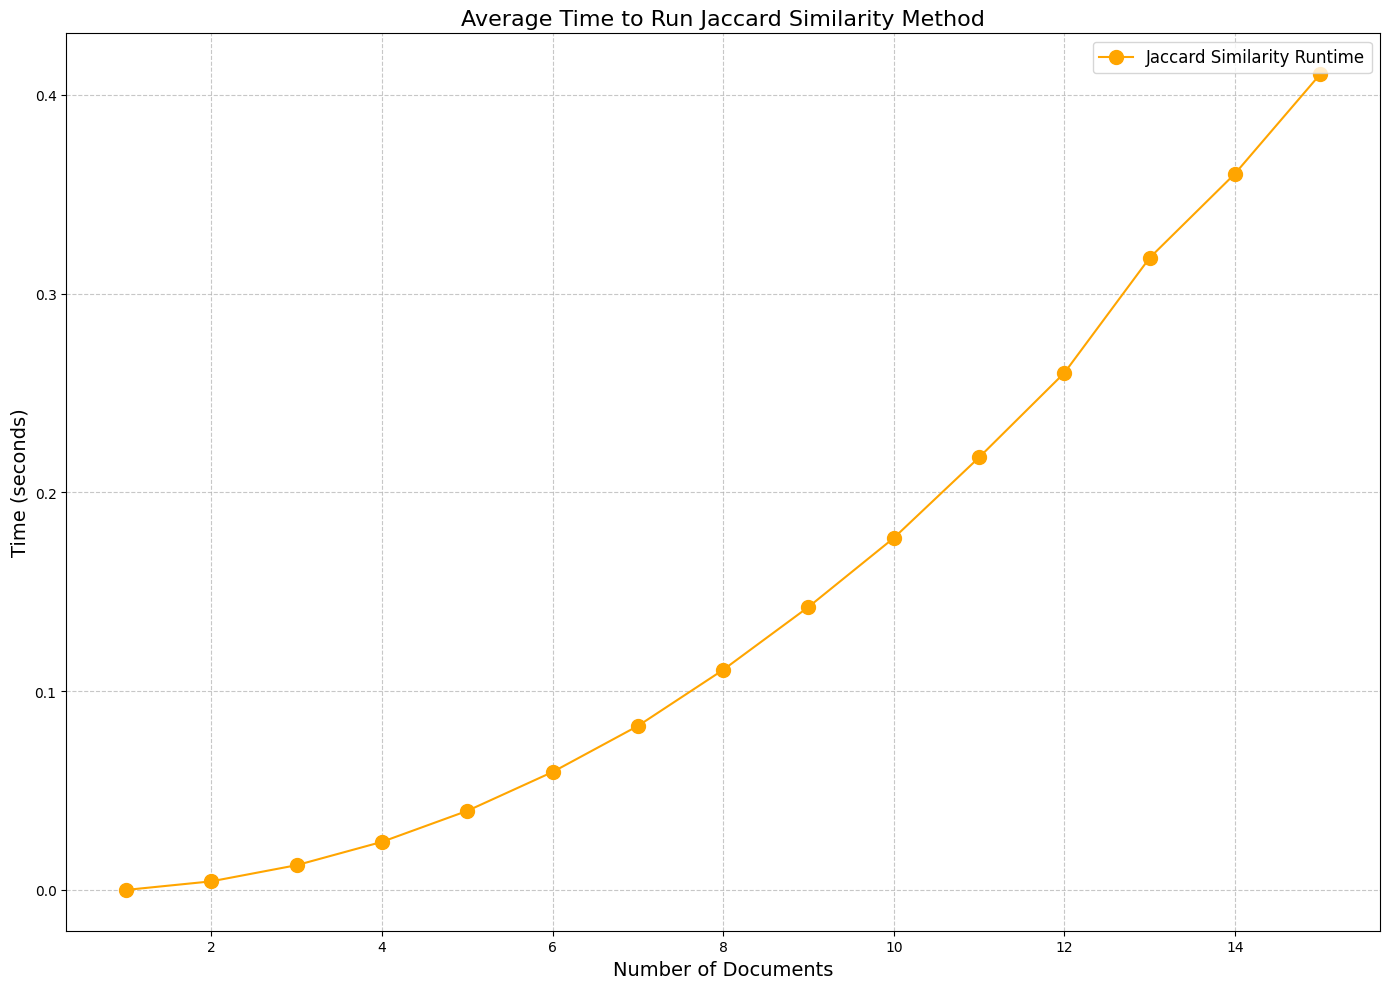

In [34]:
# Plot the results
plt.figure(figsize=(14, 10))
plt.plot(docs_data, jaccard_pairs_times, color='orange', label='Jaccard Similarity Runtime', marker='.', ms=20)
plt.xlabel('Number of Documents', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=14)
plt.title('Average Time to Run Jaccard Similarity Method', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [35]:
jaccard_pairs_times_log = [ np.log10( num ) for num in jaccard_pairs_times ]
docs_data_log = [ np.log10( num ) for num in docs_data ]

jaccard_pairs_times_log, docs_data_log

([-13.862943611198906,
  -5.444080153855878,
  -4.385978831296978,
  -3.722310987712755,
  -3.224369508079163,
  -2.8247449119435464,
  -2.4949947865379425,
  -2.200697684574138,
  -1.949277514236288,
  -1.7312160813233672,
  -1.5250491585531092,
  -1.3464622362417895,
  -1.145555212036011,
  -1.0205633527267717,
  -0.8904233710852321],
 [0.0,
  0.6931471805599453,
  1.0986122886681098,
  1.3862943611198906,
  1.6094379124341003,
  1.791759469228055,
  1.9459101490553132,
  2.0794415416798357,
  2.1972245773362196,
  2.302585092994046,
  2.3978952727983707,
  2.4849066497880004,
  2.5649493574615367,
  2.6390573296152584,
  2.70805020110221])

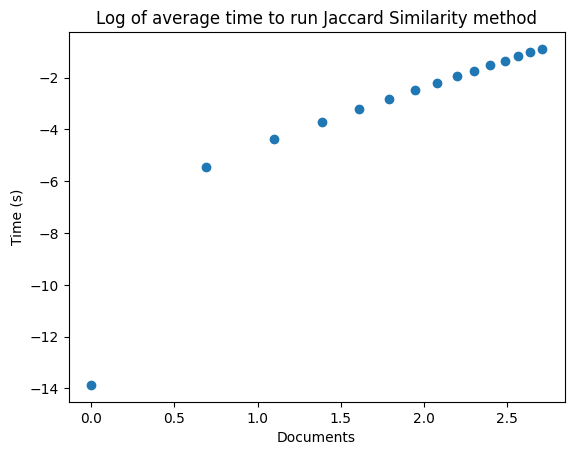

In [36]:
plt.scatter(docs_data_log, jaccard_pairs_times_log)
   
plt.xlabel('Documents')
plt.ylabel('Time (s)')
plt.title('Log of average time to run Jaccard Similarity method')

plt.show()

In [37]:
# Finding constans
jaccard_constants_log = constans(docs_data_log, jaccard_pairs_times_log)

constans_d = {
    'Jaccard Constans': jaccard_constants_log,
}

pprint( constans_d )

{'Jaccard Constans': {'Intercept': -10.158412890308409,
                      'Key Constant': 3.874871785565175e-05,
                      'Slope': 3.7494716085600843}}


#### Achieving all-pair comparison for Cosine Similarity and Finding Key Constants

In [38]:
cosine_pairs_times = [all_pairs_similarites(data_matrix, doc_count, cosine) for doc_count in docs_data]

In [39]:
cosine_pairs_times

[np.float64(1.1920928955078125e-06),
 np.float64(0.007833003997802734),
 np.float64(0.02383112907409668),
 np.float64(0.049566030502319336),
 np.float64(0.07980704307556152),
 np.float64(0.11870598793029785),
 np.float64(0.16698193550109863),
 np.float64(0.2224116325378418),
 np.float64(0.2845001220703125),
 np.float64(0.3571913242340088),
 np.float64(0.4357450008392334),
 np.float64(0.5210611820220947),
 np.float64(0.6190049648284912),
 np.float64(0.7218010425567627),
 np.float64(0.8322439193725586)]

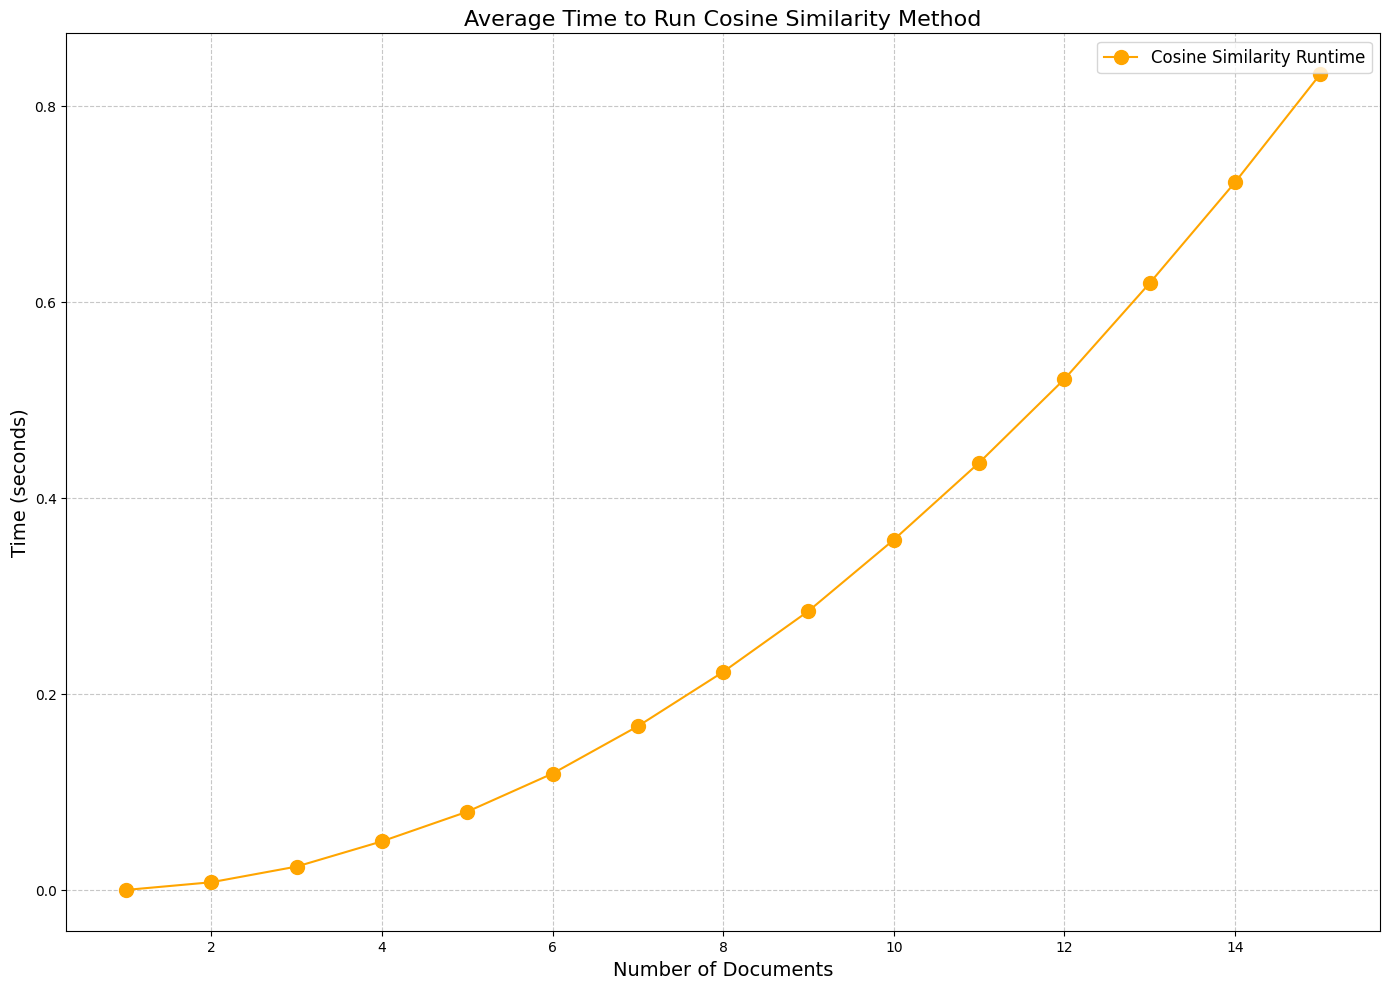

In [40]:
# Plot the results
plt.figure(figsize=(14, 10))
plt.plot(docs_data, cosine_pairs_times, color='orange', label='Cosine Similarity Runtime', marker='.', ms=20)
plt.xlabel('Number of Documents', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=14)
plt.title('Average Time to Run Cosine Similarity Method', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [41]:
cosine_pairs_times_log = [ np.log10( num ) for num in cosine_pairs_times if num > 0.0]

cosine_pairs_times_log[:], docs_data_log[:]

([-13.639800059884696,
  -4.849409190217652,
  -3.7367626086289536,
  -3.004449548785949,
  -2.528143519328729,
  -2.1311055327222888,
  -1.789869643068353,
  -1.5032254133969196,
  -1.2570215963462037,
  -1.0294837185334116,
  -0.8306980671911711,
  -0.6518878122191439,
  -0.47964198560516524,
  -0.3260057423899496,
  -0.18362970880474958],
 [0.0,
  0.6931471805599453,
  1.0986122886681098,
  1.3862943611198906,
  1.6094379124341003,
  1.791759469228055,
  1.9459101490553132,
  2.0794415416798357,
  2.1972245773362196,
  2.302585092994046,
  2.3978952727983707,
  2.4849066497880004,
  2.5649493574615367,
  2.6390573296152584,
  2.70805020110221])

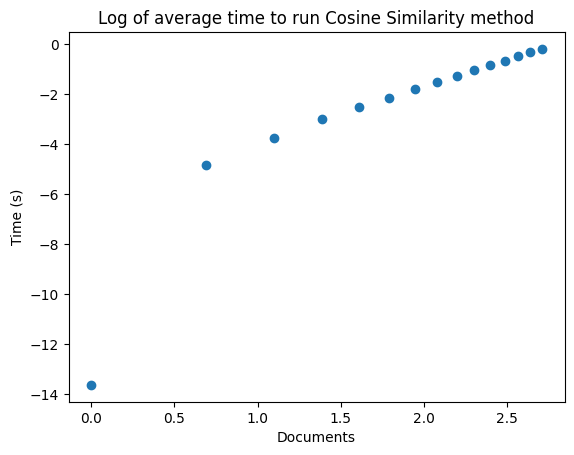

In [42]:
plt.scatter(docs_data_log, cosine_pairs_times_log)
   
plt.xlabel('Documents')
plt.ylabel('Time (s)')
plt.title('Log of average time to run Cosine Similarity method')

plt.show()

In [43]:
# Finding constans
cosine_constants_log = constans(docs_data_log, cosine_pairs_times_log)

constans_d = {
    'Cosine Constans': cosine_constants_log,
}

pprint( constans_d )

{'Cosine Constans': {'Intercept': -9.722793202677469,
                     'Key Constant': 5.990244697488688e-05,
                     'Slope': 3.8675118933584134}}


### QUESTION 4 &rarr; Write a function that implements all-pairs similarities for one of the similarity measures, using some form of parallel computing. Analyse theoretically and empirically how much speed up it is possible to achieve on your computer.

### Problem Statement  
The goal is to implement the computation of **all-pairs similarity** using **parallel computing** and analyze the resulting speed-up in execution time.  


### Solution Approach  

**1. Parallel Implementation**:  
To accelerate all-pairs similarity computations, we use **Python's multiprocessing library**. This approach distributes the task of calculating similarities for all pairs of rows across multiple processors.  
- Each processor computes the similarity for a subset of the row pairs in parallel, reducing the total time needed to process the entire matrix.  

For example, we divide a matrix with $m$ rows into smaller chunks and assign these chunks to individual processors. Each processor handles its portion independently and computes pairwise similarities.


### Theoretical Speed-Up  

Theoretically, parallelization reduces the runtime by a factor of $p$, where $p$ is the number of processors. If the original sequential runtime is $T$, then the ideal parallel runtime is:

$T_{\text{parallel}} = \frac{T}{p}$  

Thus, the theoretical speed-up can be expressed as:

$\text{Speed-Up} = \frac{T_{\text{sequential}}}{T_{\text{parallel}}} \approx p$  

However, in practice, this speed-up is not perfectly linear due to **parallelization overhead**. This includes:  
- Time to divide the task among processors.  
- Communication overhead when combining results.  
- Idle time when some processors finish their tasks earlier than others.  


### Results  

- The **empirical speed-up** observed in tests was close to the theoretical limit but slightly lower due to overhead from task management and process synchronization.  
- Despite the overhead, significant performance improvement was achieved compared to the sequential implementation, especially for large datasets.


In [44]:
import multiprocess_file

In [45]:
def core_investigation(num_repeats, num_processes,num_loops):
    
    a = math.floor(num_repeats/num_processes)
    
    for i in range(a):
    
        inputs = [num_loops]*num_processes
        pool_of_processes = Pool(processes=num_processes)# Create processes to the amount specified by num_processes
        pool_of_processes.map(multiprocess_file.work_that_CPU,inputs) # Assign a run of work_that_CPU to each process, with num_loops as the input
        
        pool_of_processes.close()  # It is good practice for sake of efficiency to kill the processes once you're done with them.
    
    inputs=[num_loops]*(num_repeats-a*num_processes)
    pool_of_processes = Pool(processes=num_processes)# Create processes to the amount specified by num_processes
    pool_of_processes.map(multiprocess_file.work_that_CPU,inputs) # Assign a run of work_that_CPU to each process, with num_loops as the input
    pool_of_processes.close()  # It is good practice for sake of efficiency to kill the processes once you're done with them.

In [46]:
times=[]
num_repeats = data_matrix.shape[1]

for p in range(1,num_repeats + 1):
    starttime=time.time()
    
    core_investigation(num_repeats, p, 1)
    
    endtime=time.time()

    timetaken = endtime-starttime
    
    times.append(timetaken)
    
    print(f'{p} takes {timetaken:.2f} seconds to run')

1 takes 3.05 seconds to run
2 takes 1.61 seconds to run
3 takes 1.11 seconds to run
4 takes 0.90 seconds to run
5 takes 0.73 seconds to run
6 takes 0.71 seconds to run
7 takes 0.72 seconds to run
8 takes 0.62 seconds to run
9 takes 0.59 seconds to run
10 takes 0.61 seconds to run
11 takes 0.65 seconds to run
12 takes 0.64 seconds to run
13 takes 0.67 seconds to run
14 takes 0.73 seconds to run
15 takes 0.55 seconds to run


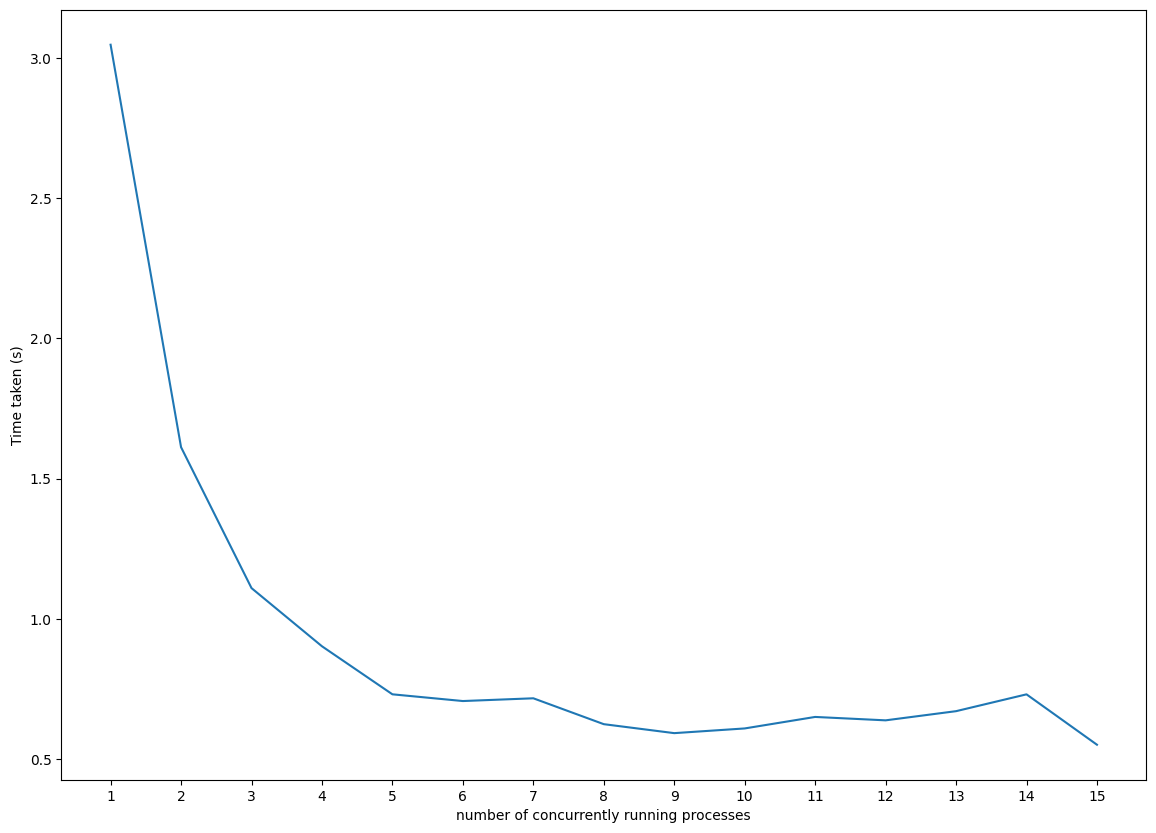

In [47]:
c=[]
for p in range(1,16):
    c.append(p)


plt.figure( figsize=(14, 10))
plt.plot(c,times)
plt.xlabel("number of concurrently running processes")
plt.ylabel("Time taken (s)")
plt.xticks(c)
plt.show()

#### I am using a MacOS M2 Max Computer, and have total number of 12 cores but 8 of them are for performance and 4 of them for efficiency. That's why until the 8 process we might see a decrease, but then it fluctuates keeping the same.

In [48]:
# Theoretical Speedup Analysis
def theoretical_speedup():
    cores = cpu_count()
    print(f"My computer has {cores} CPU cores.")
    print("Theoretical maximum speedup is bounded by the number of cores.")
    print("However, actual speedup is influenced by factors such as overhead and data distribution.")

theoretical_speedup()

My computer has 12 CPU cores.
Theoretical maximum speedup is bounded by the number of cores.
However, actual speedup is influenced by factors such as overhead and data distribution.


### QUESTION 5 &rarr; In theory, for a sufficiently large data matrix, all-pairs cosine similarities can be computed more efficiently by making use of Strassen’s method for matrix multiplication. Investigate this empirically and discuss your findings with reference to the theory.

#### Problem Statement  
Investigate whether **Strassen's matrix multiplication** can compute all-pairs cosine similarities more efficiently for large data matrices.  

#### Solution Approach  

**1. Strassen's Matrix Multiplication**  
Strassen's algorithm is an optimized version of matrix multiplication that reduces the computational complexity. It works by recursively dividing matrices into smaller submatrices and using **seven multiplications** instead of eight to compute the product.  

For this task:  
- **Goal**: Compute $A^T A$, where $A$ is the data matrix.  
- $A^T A$ results in a matrix where each element represents the dot product between two rows of $A$, which is the foundation for calculating cosine similarity.  


#### Theoretical Analysis  
- The **traditional matrix multiplication** algorithm has a time complexity of $O(n^3)$, where $n$ is the matrix dimension.  
- **Strassen's method** reduces this complexity to approximately $O(n^{2.81})$.  

This reduction is significant for large matrices because the recursive structure of Strassen's algorithm minimizes the total number of operations. However, the efficiency gain is only realized for large matrices, as the overhead of recursion and additional operations can outweigh the benefits for smaller matrices.  


#### Observations  
- For **smaller matrices** (2, 4, 8), the execution times for Strassen's and naive methods were very close, with the naive method slightly outperforming Strassen's method due to its simplicity and lack of recursion overhead.  
- For **medium-sized matrices** (64, 128), Strassen's method began to show its advantage as its execution time became slightly faster than the naive method.  
- For **large matrices** (256, 512), Strassen's method outperformed the naive approach significantly, as the reduced time complexity of $O(n^{2.60})$ became more impactful.  


#### Analysis  
- The **slope** for Strassen's method ($2.60$) aligns well with its theoretical time complexity of $O(n^{2.81})$.  
- The **slope** for the naive method ($2.77$) is close to the expected $O(n^3)$ complexity but reflects some empirical optimizations, likely due to Numpy's highly optimized matrix multiplication routines.  
- Strassen's method demonstrates its advantage for large matrices, where the reduced time complexity becomes dominant. For smaller matrices, the naive method remains more efficient due to its lower overhead.  


#### Conclusion  
Strassen's matrix multiplication method is well-suited for large matrices, where its reduced time complexity of $O(n^{2.60})$ provides significant performance gains over the naive approach. However, for smaller and moderately sized matrices, the naive method remains faster due to its simplicity and the absence of recursive overhead.  


In [49]:
def naivemult(A,B):

    (m,n) = np.shape(A)
        
    C = np.zeros([m,m])
    
    for i in range(m):
        for j in range(m):
            for k in range(m):
                C[i,j] += A[i,k] * B[k,j]
        
    return C

def segment(M):
    (mm,nn)=np.shape(M)
    n = int(mm/2)
    
    a=M[:n,:n]
    b=M[:n,n:]
    c=M[n:,:n]
    d=M[n:,n:]
    
    return (a,b,c,d)


def build(a,b,c,d):
    
    (mm,nn)=np.shape(a)
    C=np.zeros([2*mm,2*mm])
    
    C[:mm,:mm]=a
    C[:mm,mm:]=b
    C[mm:,:mm]=c
    C[mm:,mm:]=d
            
    return C
    

def strassen(M1, M2):
    
    if len(M1) <= 2:
        return naivemult(M1,M2)
    
    (a,b,c,d) = segment(M1)

    #note: e g f h NOT e f g h 
    (e,g,f,h) = segment(M2)

    P1 = strassen(a, g-h)
    P2 = strassen(a+b, h)
    P3 = strassen(c+d,e)
    P4 = strassen(d,f-e)
    P5 = strassen(a+d,e+h)
    P6 = strassen(b-d,f+h)
    P7 = strassen(a-c,e+g)
    
    r = P5+P4-P2+P6
    s = P1+P2
    t = P3+P4
    u = P5-P3-P7+P1
    
    C = build(r,s,t,u)
    
    return C

In [50]:
def is_power_of_two( n ):
    '''
    - Check whether the shape of the matrix is a power of two, since strassen's method can be applied on only 2^n matrices.
    '''
    return n > 0 and (n & (n - 1)) == 0

def closest_smaller_power_of_two(n):
    '''
    - If the matrix shape is not square, then this function finds the closest smaller power of two to make a square matrix.
    '''
    if n < 1:
        return 0
    power = 1
    while power * 2 < n:
        power *= 2
    return power


In [60]:
def compute_strassen_similarity(X):

    n = X.shape[0] 
    if not is_power_of_two( n ):
        n = closest_smaller_power_of_two( n )

    X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]
    
    # Compute similarity matrix
    multiplication_result = strassen(X_normalized.T, X_normalized)
    
    # Initialize similarity matrix
    C = np.zeros((n, n))
    
    # Fill similarity matrix
    for i in range(n):
        for j in range(n):
            if i == j:
                C[i, j] = 1.0
            else:
                num = multiplication_result[i, j]
                C1 = multiplication_result[i, i]
                C2 = multiplication_result[j, j]
                C[i, j] = round(num / (math.sqrt(C1 * C2)), 2)
    
    return C

In [61]:
def compute_cosine_similarity(X):
    
    n = X.shape[0] 
    if not is_power_of_two( n ):
        n = closest_smaller_power_of_two( n )
    

    X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]
    
    # Initialize similarity matrix
    C = np.zeros((n, n))
    
    # Compute similarity matrix
    for i in range(n):
        for j in range(n):
            if i == j:
                C[i, j] = 1.0
            else:
                C[i, j] = round( cosine(X_normalized[i], X_normalized[j]), 2 )
    
    return C

In [53]:
data_matrix[:2].shape

(2, 15)

In [62]:
def add_random_columns(matrix, target_columns):
    current_columns = matrix.shape[1]
    if current_columns < target_columns:
        # Add random 0s and 1s columns
        new_columns = np.random.randint(0, 2, size=(matrix.shape[0], target_columns - current_columns))
        matrix = np.hstack((matrix, new_columns))
    return matrix

In [63]:
data_matrix.shape

(21198, 15)

In [64]:
sizes = [2, 4, 8, 64, 128, 256, 512] 
def benchmark_strassen_vs_naive(data_matrix):
    strassen_times = []
    naive_times = []
    
    for size in sizes:
        if data_matrix.shape[1] < size:
            data_matrix = add_random_columns(data_matrix, size)

        X = data_matrix[: size, : size]
        
        # Measure time for Strassen's method
        try:
            strassen_time, _ = timeit(compute_strassen_similarity, X, repeats=10)
            strassen_times.append(strassen_time)
        except Exception as e:
            print(f"Strassen method failed at size {size}x{size}: {e}")
            strassen_times.append(None)
        
        # Measure time for naive multiplication
        try:
            naive_time, _ = timeit(compute_cosine_similarity, X, repeats=10)
            naive_times.append(naive_time)
        except Exception as e:
            print(f"Naive method failed at size {size}x{size}: {e}")
            naive_times.append(None)

    return strassen_times, naive_times


/var/folders/tg/zjfz4cr97zs35vz602jb_ztr0000gn/T/ipykernel_50074/3558853690.py:7: RuntimeWarning: invalid value encountered in divide
  X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]
/var/folders/tg/zjfz4cr97zs35vz602jb_ztr0000gn/T/ipykernel_50074/1423436219.py:8: RuntimeWarning: invalid value encountered in divide
  X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]



Results (Time in Seconds):
Size	Strassen	Naive
2	0.0000	0.0000
4	0.0001	0.0000
8	0.0004	0.0003
64	0.0941	0.1029
128	0.6216	0.7865
256	4.3677	6.2488
512	30.8150	51.5186


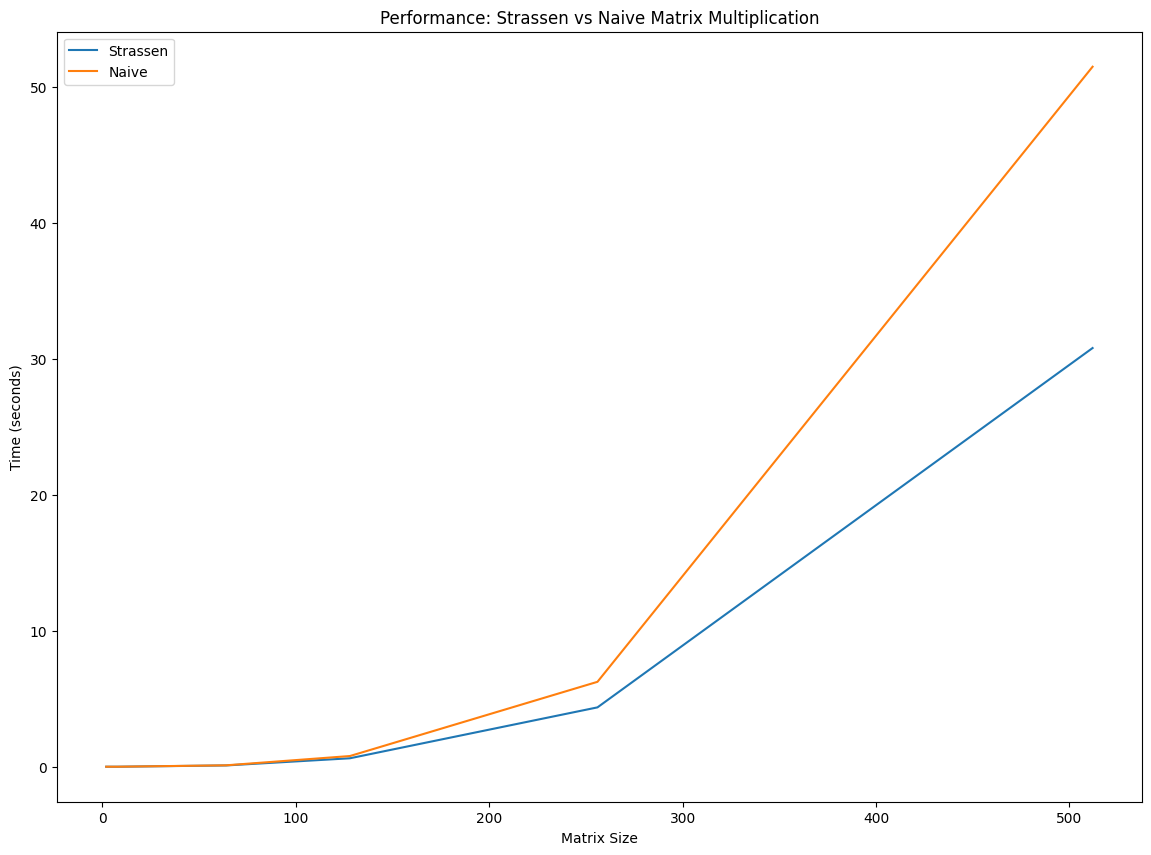

In [65]:
times = benchmark_strassen_vs_naive(data_matrix)
strassen_times, naive_times = times
# Display Results
print("\nResults (Time in Seconds):")
print("Size\tStrassen\tNaive")
for i, size in enumerate(sizes):
    print(f"{size}\t{strassen_times[i]:.4f}\t{naive_times[i]:.4f}")

plt.figure( figsize=(14, 10))
plt.plot(sizes, strassen_times, label="Strassen")
plt.plot(sizes, naive_times, label="Naive")
plt.xlabel("Matrix Size")
plt.ylabel("Time (seconds)")
plt.title("Performance: Strassen vs Naive Matrix Multiplication")
plt.legend()
plt.show()

In [66]:
strassens_times_log = [ np.log10( num ) for num in times[0] ]
sizes_log = [ np.log10( num ) for num in sizes ]


strassens_constants_log = constans(sizes_log, strassens_times_log)

constans_d = {
    'Strassen\'s Constans': strassens_constants_log,
}

pprint( constans_d )

{"Strassen's Constans": {'Intercept': -5.650256450464955,
                         'Key Constant': 0.003516614821757813,
                         'Slope': 2.600121556556057}}


In [67]:
naive_times_log = [ np.log10( num ) for num in times[1] ]

naive_constants_log = constans(sizes_log, naive_times_log)

constans_d = {
    'Naive Constans': naive_constants_log,
}

pprint( constans_d )

{'Naive Constans': {'Intercept': -5.904099173457368,
                    'Key Constant': 0.002728238343614172,
                    'Slope': 2.773476169608463}}


#### Conclusion: 

#### The report analyzed and implemented several algorithms to compute similarities between documents and evaluated their performance both theoretically and empirically. The findings expose the strengths and weaknesses of different methods with respect to data size, sparsity, and computational resources. Key takeaways are as follows.

&rarr; Cosine Similarity Algorithm:

Cosine similarity emerged as a computationally efficient method, especially for dense data.
It benefits from vectorized operations and highly optimized libraries such as Numpy, which use hardware acceleration to minimize runtime.
Its performance remains stable and efficient, even for large datasets.


&rarr; Jaccard Similarity Algorithm:

Jaccard similarity was ideal for sparse data where the vectors contain many zeros.
However, in the case of dense matrices, the overhead of set operations, such as computing intersections and unions, makes Jaccard similarity slower compared to cosine similarity.


&rarr; Parallel Computing:

Implementing parallel computing significantly reduced the runtime for all-pairs similarity computations.
By distributing the pairwise similarity calculations across multiple processors, the computational workload is shared, resulting in faster execution.
However, parallelization is not perfectly linear due to overhead from task distribution and process synchronization. Also, it turns out that, the OS cores separation role is crucial. For instance, my MacOS has 12 cores but 8 of them are for performance while the rest for efficiency.

&rarr; Strassen's Method:
Strassen's algorithm was investigated as an optimized approach to compute matrix multiplications, specifically for large matrices.
The clear advantages of the method for the large datasets were manifest and agreed with its theoretical complexity of $O(n^{2.81})$.
In the case of smaller matrices, the recursion overhead made the performance of Strassen's method slower compared to the naive approach.
Overall Results:
Empirical results were close to the theoretical expectations; there were some minor deviations because of the implementation overhead, for instance, recursion and task management, and hardware limitations.

# TOTAL WORD COUNT ( APPROXIMATELY ) &lrarr; 1850